# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | You may never see your ref...
1,Not Verified | Cargo service: that's how I fel...
2,✅ Trip Verified | Inefficient and slow airport...
3,Not Verified | The customer service is one of...
4,"Not Verified | Before my flight, I was forced ..."


In [5]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

# Task 2
---

## Data Cleaning

References: <br>
Text Data Preprocessing Made Easy: Steps to Clean Text Data Using Python
[https://medium.com/@pawan329/text-data-preprocessing-made-easy-steps-to-clean-text-data-using-python-81a138a0e0e3]

In [22]:
from nltk.corpus import stopwords
import re
import string
import nltk
nltk.download(["stopwords", "punkt", "punkt_tab", "book_grammars",
              "large_grammars", "wordnet"], raise_on_error=True)

[nltk_data] Downloading package stopwords to C:\Users\Zidan
[nltk_data]     Arsyad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Zidan
[nltk_data]     Arsyad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Zidan
[nltk_data]     Arsyad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package book_grammars to C:\Users\Zidan
[nltk_data]     Arsyad\AppData\Roaming\nltk_data...
[nltk_data]   Package book_grammars is already up-to-date!
[nltk_data] Downloading package large_grammars to C:\Users\Zidan
[nltk_data]     Arsyad\AppData\Roaming\nltk_data...
[nltk_data]   Package large_grammars is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Zidan
[nltk_data]     Arsyad\AppData\Roaming\nltk_data...


True

### Preprocess Text

In [7]:
def preprocess_text(text):
    # Remove "verified" portion
    text = text.split("|")[1]

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits using regex
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Tokenize/split the text
    tokens = nltk.word_tokenize(text)

    return tokens

### Remove stopwords

Remove word articles, "and", "is", "the", etc.

In [8]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens

### Stemming vs Lemmatization

<ul>
  <li>Stemming is reducing words to their root form ("changed", "changes", "change") to "chang".
  <li>Lemmatization is converting words to their base form ("changed", "changes", "change") to "change".
</ul>

In [9]:
def perform_lemmatization(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens

### Putting it all together

In [10]:
def clean_text(text):
    tokens = preprocess_text(text)
    filtered_tokens = remove_stopwords(tokens)
    lemmatized_tokens = perform_lemmatization(filtered_tokens)
    clean_text = " ".join(lemmatized_tokens)

    return clean_text

### Testing

In [23]:
df_clean = df["reviews"].apply(clean_text)

In [24]:
df_clean.head()

0    may never see refund cancelled return flight s...
1    cargo service thats felt upper deck supposedly...
2    inefficient slow airport operation resting lau...
3    customer service one worst ever seen scheme gi...
4    flight forced ground staff check new expensive...
Name: reviews, dtype: object

# Task 3
---

## Sentiment analysis

Resources: <br>
NLTK Sentiment Analysis Tutorial for Beginners [https://www.datacamp.com/tutorial/text-analytics-beginners-nltk]

# Task 4
---

## Word Cloud
References: <br>
WordClouds with Python [https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b]

In [25]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [88]:
ba_mask = np.array(Image.open("./British Airways Logo.png"))

(-0.5, 999.5, 999.5, -0.5)

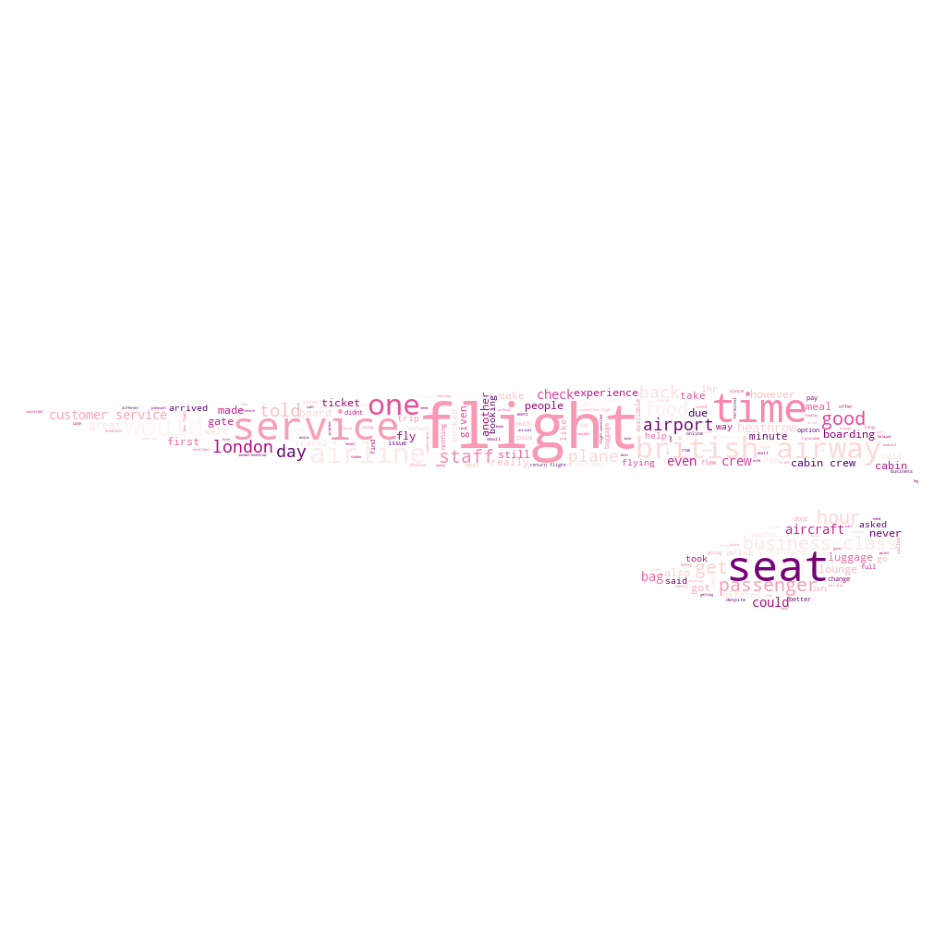

In [94]:
wc = WordCloud(background_color="white", mask=ba_mask, colormap="RdPu_r", stopwords=["u", "ba", "british airway", "british airways"],
               width=800, height=800).generate(" ".join(df_clean))
plt.figure(figsize=(12, 12))
plt.imshow(wc)
plt.axis("off")

#### Word Cloud POS (Part-of Speech) tagging

Improving word cloud by selecting only some tags (nouns, adjective, verb, and adverbs)

In [110]:
def filter_pos_tag(text):
    tokens = nltk.word_tokenize(text)
    pos_tagged = nltk.pos_tag(tokens)

    filters = ["JJ", "JJR", "JJS", "NN", "NNP", "NNS", "NNPS",
               "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
    filtered_tokens = [token for token,
                       label in pos_tagged if label in filters]

    filtered_text = " ".join(filtered_tokens)

    return filtered_text

In [97]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [111]:
df_pos_tag = df_clean.apply(filter_pos_tag)

(-0.5, 999.5, 999.5, -0.5)

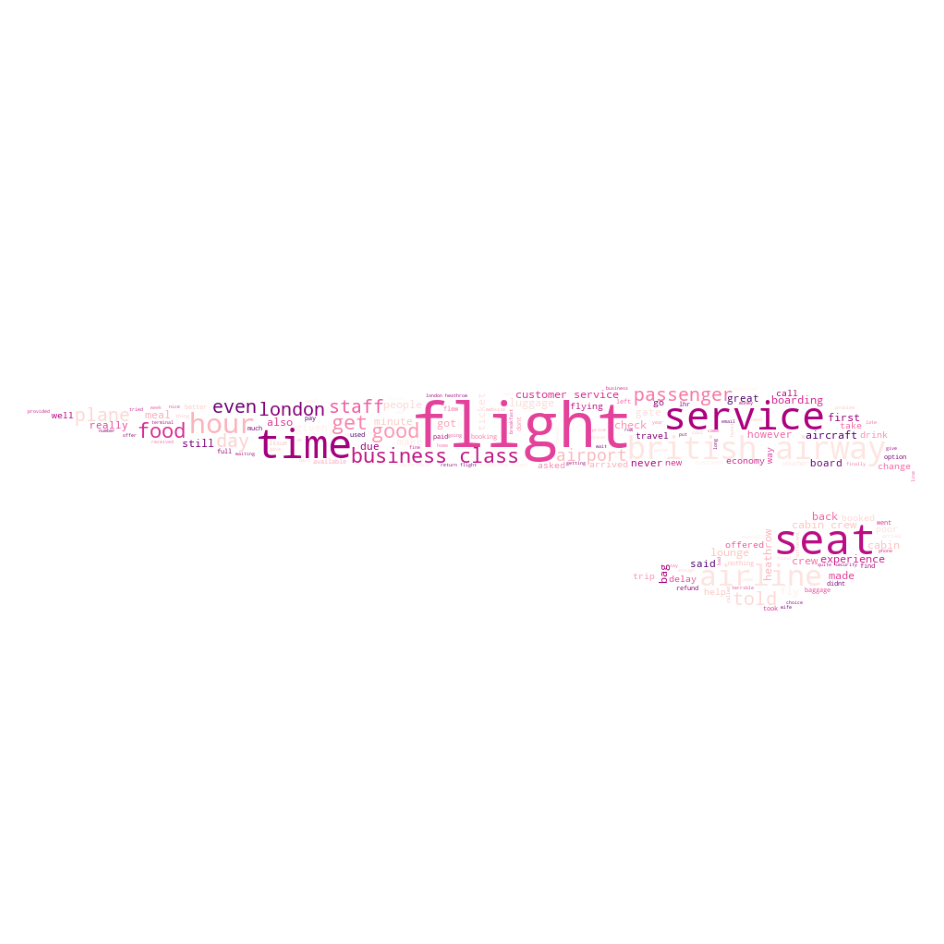

In [112]:
wc = WordCloud(background_color="white", mask=ba_mask, colormap="RdPu_r", stopwords=["u", "ba", "british airway", "british airways"],
               width=800, height=800).generate(" ".join(df_pos_tag))
plt.figure(figsize=(12, 12))
plt.imshow(wc)
plt.axis("off")